In [1]:
import os
import tqdm
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from alignment_helper_fns import *

In [2]:
satdf = pd.read_csv('./results_sat/results.csv').set_index('Unnamed: 0')
xsatdf = pd.read_csv('./results_sat_xvector/results_xvector_proj.csv')
xsatdf = xsatdf.rename(columns={'Unnamed: 0': 'Speaker'})


results_dir_frame = './results_frame_10epochs'
results_dir_ivec = './results_sat'
results_dir_xvec = './results_sat_xvector'

In [3]:
%%capture
speaker_tgs = {}
for speakerid in list(satdf.index):
    tg_dct = {}
    
    tg_dct['Manual'] = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid))
    tg_dct['Frame'] = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid))
    tg_dct['xvector'] = get_all_textgrids_in_directory(os.path.join('./results_sat_xvector', speakerid))
    tg_dct['ivector'] = get_all_textgrids_in_directory(os.path.join('/results_sat', speakerid))
        
    speaker_tgs[speakerid] = tg_dct

In [4]:
phone = ENGLISH_PHONEME_LIST[0]
spkid = satdf.index[0]
tgs_frame = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid))



Extracting all textgrids in directory:	 ./results_frame_10epochs/0506_F_LH


1it [00:00, 541.69it/s]


In [5]:
def phone_in_tg(tg, phone, count=False):
    tgphones = np.unique(tg.iloc[:, 2].values).ravel()
    return phone in tgphones

def get_phonecount(tg, phone, key=None, loc=None):
    return sum(tg.iloc[:, 2].values==phone)

def get_phone_startend(tg, phone, key=None, loc=None):
    if key is not None:
        loc = np.argwhere(tg.columns==key).ravel()[0]
    
    tgphonedf = tg[tg.loc[:, 2]==phone]
    starttimes = tgphonedf.iloc[:, 0].values
    endtimes = tgphonedf.iloc[:, 1].values
    return starttimes, endtimes

def get_onoff_error(tg_gt, tg_estim, phone, verbose=False):
    gtstart, gtend = get_phone_startend(tg_gt, phone, loc=2)
    start, end = get_phone_startend(tg_estim, phone, loc=2)
    if len(gtstart) != len(start):
        if verbose:
            print('Exception for phone [%s]: Ground truth has %d %ss, estimate has %d %ss' % (phone, len(gtstart), phone, len(start), phone))
            print(tg)
            print(tg_gt)
        duration_gt = np.array([np.nan])
        duration_est = np.array([np.nan])
        
        duration_err = np.array([np.nan])
        onset_err = np.array([np.nan])
        offset_err = np.array([np.nan])
        error_indicator = True
    else:
        duration_gt = gtend - gtstart
        duration_est = end - start
        duration_err = duration_gt - duration_est
        onset_err = gtstart - start    
        offset_err = gtend - end
                
    # if len(duration_est) != len(offset_err):
    #         print('-----------------------------------------------------------------')
    #         print('Error Mismatch!')
    #         print('Gt start', gtstart, '\tLen', len(gtstart))
    #         print('Est Start', start, '\tLen', len(start))
    #         print('Durations Est:\t', duration_est, '\tLen', len(duration_est))
    #         print('OnsetErr', onset_err, '\tLen', len(onset_err))
    #         print('OffsetErr', offset_err, '\tLen', len(offset_err))
    #         # print(len(duration_est), duration_est)
    #         # print(len(onset_err), )
    #         # print(tg)
    #         # print(tg_gt)

    return onset_err, offset_err, duration_err, duration_gt, duration_est

def get_phone_durations(tg, phone, key=None, loc=None):
    if key is not None:
        loc = np.argwhere(tg.columns==key).ravel()[0]
        
    start, end = get_phone_startend(tg, phone, loc=2)
    
    return end - start
    
    
def tg_error(tg_gt, tg_estim, phone, loc=2, verbose=False):
    stats = {}
    
    onset_err, offset_err, duration_error, duration_gt, duration_est = get_onoff_error(tg_gt, tg_estim, phone, verbose=verbose)
    
    stats['durations_gt'] = duration_gt
    stats['durations_est'] = duration_est
    stats['onset_error'] = onset_err
    stats['offset_error'] = offset_err
    stats['duration_error'] = duration_error
    
    return stats

def get_gt_tg(manual_tgpaths, target_tgpath, phone_key='ha phones'):
    fname = target_tgpath.split('/')[-1]
    idx = np.argwhere([fname in mtg for mtg in manual_tgpaths]).ravel()[0]
    return textgridpath_to_phonedf(manual_tgpaths[idx], phone_key=phone_key, remove_numbers=True)

In [6]:
# 'phone': [phone] * len(durations_gt['frame']), 'duration_gt': durations_gt['frame'], 'duration_est':durations_est['frame'], 
# 'onset_err_frame': onset_err['frame'], 'offset_err_frame': offset_err['frame']
# print(len(durations_gt['frame']))
print(len(durations_est['frame']))
print(len(onset_err['frame']))
print(len(offset_err['frame']))
    

NameError: name 'durations_est' is not defined

In [9]:

if not os.path.exists('./outputs/gt_dfs.pkl') and os.path.exists('./outputs/phone_accuracy_dfs.pkl'):
    phone_durations = {}
    phone_onset_err = {}
    phone_offset_err = {}
    phone_ids = {}
    age = {}
    nexclude_per = {}

    phone_dfs = {'frame': {}, 'ivector': {}, 'xvector': {}}
    finish = False

    gt_dfs = {}
    for phone in tqdm.tqdm(ENGLISH_PHONEME_LIST):
        print('Calculating error for phone: \t ', phone)
        durations_gt = {}
        durations_est = {}
        onset_err = {}
        offset_err = {}

        nfiles_error = {}

        phone_dfs[phone] = {}

        phone_ids['frame'] = []
        phone_ids['ivector'] = []
        phone_ids['xvector'] = []

        durations_est['frame'] = []
        durations_est['ivector'] = []
        durations_est['xvector'] = []

        durations_gt['frame'] = []
        durations_gt['ivector'] = []
        durations_gt['xvector'] = []

        onset_err['frame'] = []
        onset_err['ivector'] = []
        onset_err['xvector'] = []

        offset_err['frame'] = []    
        offset_err['ivector'] = []
        offset_err['xvector'] = []

        nfiles_error['frame'] = 0
        nfiles_error['ivector'] = 0
        nfiles_error['xvector'] = 0 

        start_gt = []
        end_gt = []
        durations_gt = []
        speaker_id = []
        #iterate over speakers
        for speakerid in list(satdf.index):
            # print('Analyzing speaker:    ', speakerid)
            # print(speakerid)
            tgs_manual = get_all_textgrids_in_directory(os.path.join('/home/prad/datasets/ChildSpeechDataset/manually-aligned-text-grids/', speakerid), verbose=False)
            tgs_frame = get_all_textgrids_in_directory(os.path.join('./results_frame_10epochs', speakerid), verbose=False)
            tgs_xv = get_all_textgrids_in_directory(os.path.join('./results_sat_xvector', speakerid), verbose=False)
            tgs_iv = get_all_textgrids_in_directory(os.path.join('./results_sat', speakerid), verbose=False)


            for manual_tgpath in tgs_manual:
                manual_tg = textgridpath_to_phonedf(manual_tgpath, phone_key='ha phones', remove_numbers=True)
                gtstart, gtend = get_phone_startend(manual_tg, phone, loc=2)
                durations_gt.extend(list((gtend - gtstart) * 1000))
                speaker_id.extend([speakerid] * len(gtstart))
                start_gt.extend(list(gtstart * 1000))
                end_gt.extend(list(gtend * 1000))


            for tgpath in tgs_frame:
                tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
                tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

                if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
                    metrics = tg_error(tg_gt, tg, phone)
                    # print('-----------')
                    durations_est['frame'].extend(list(metrics['durations_est'] * 1000))
                    onset_err['frame'].extend(list(metrics['onset_error'] * 1000))
                    offset_err['frame'].extend(list(metrics['offset_error'] * 1000))

                    if any(np.isnan(metrics['onset_error'])):                
                        nfiles_error['frame']+=1
                        # print(tgpath)


            for tgpath in tgs_iv:
                tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
                tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

                if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
                    metrics = tg_error(tg_gt, tg, phone)
                    # print('-----------')
                    durations_est['ivector'].extend(list(metrics['durations_est'] * 1000))
                    onset_err['ivector'].extend(list(metrics['onset_error'] * 1000))
                    offset_err['ivector'].extend(list(metrics['offset_error'] * 1000))

                    if any(np.isnan(metrics['onset_error'])):                
                        nfiles_error['ivector'] += 1

            finished = False
            for tgpath in tgs_xv:
                tg = textgridpath_to_phonedf(tgpath, phone_key='phones', remove_numbers=True)
                tg_gt = get_gt_tg(tgs_manual, target_tgpath=tgpath)

                if phone_in_tg(tg, phone) and phone_in_tg(tg_gt, phone):
                    metrics = tg_error(tg_gt, tg, phone)
                    # print('-----------')
                    durations_est['xvector'].extend(list(metrics['durations_est'] * 1000))
                    onset_err['xvector'].extend(list(metrics['onset_error'] * 1000))
                    offset_err['xvector'].extend(list(metrics['offset_error'] * 1000))

                    if any(np.isnan(metrics['onset_error'])):
                        nfiles_error['xvector'] += 1
            # if finished:
                # break

        # if finished:
            # break
        df_gt = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt), 'speakerid': speaker_id, 'start_time': start_gt, 'end_time': end_gt})
        # df_frame = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['frame']), 'duration_gt': durations_gt['frame'], 'duration_est':durations_est['frame'], 
        df_frame = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['frame']), 'duration_est':durations_est['frame'], 'onset_err_frame': onset_err['frame'], 'offset_err_frame': offset_err['frame']})

        # df_ivec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['ivector']), 'durations_gt':durations_gt['ivector'], 'duration_est_ivector': durations_est['ivector'], 
        df_ivec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['ivector']), 'duration_est_ivector': durations_est['ivector'], 
                                          'onset_err_ivector': onset_err['ivector'], 'offset_err_ivector': offset_err['ivector']})

        # df_xvec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_gt['xvector']), 'durations_gt':durations_gt['xvector'], 'durations_est_xvector': durations_est['xvector'], 
        df_xvec = pd.DataFrame.from_dict({'phone': [phone] * len(durations_est['xvector']), 'duration_est_xvector': durations_est['xvector'], 
                                          'onset_err_xvector': onset_err['xvector'], 'offset_err_xvector': offset_err['xvector']})

        gt_dfs[phone] = df_gt
        phone_dfs[phone]['frame'] = df_frame
        phone_dfs[phone]['ivector'] = df_ivec
        phone_dfs[phone]['xvector'] = df_xvec
else:
    gt_dfs = pkl.load(open('./outputs/gt_dfs.pkl', 'rb'))
    phone_dfs = pkl.load(open('./outputs/phone_accuracy_dfs.pkl', 'rb'))

----------------------------------------------------------------------------------------------------------------------
Durations


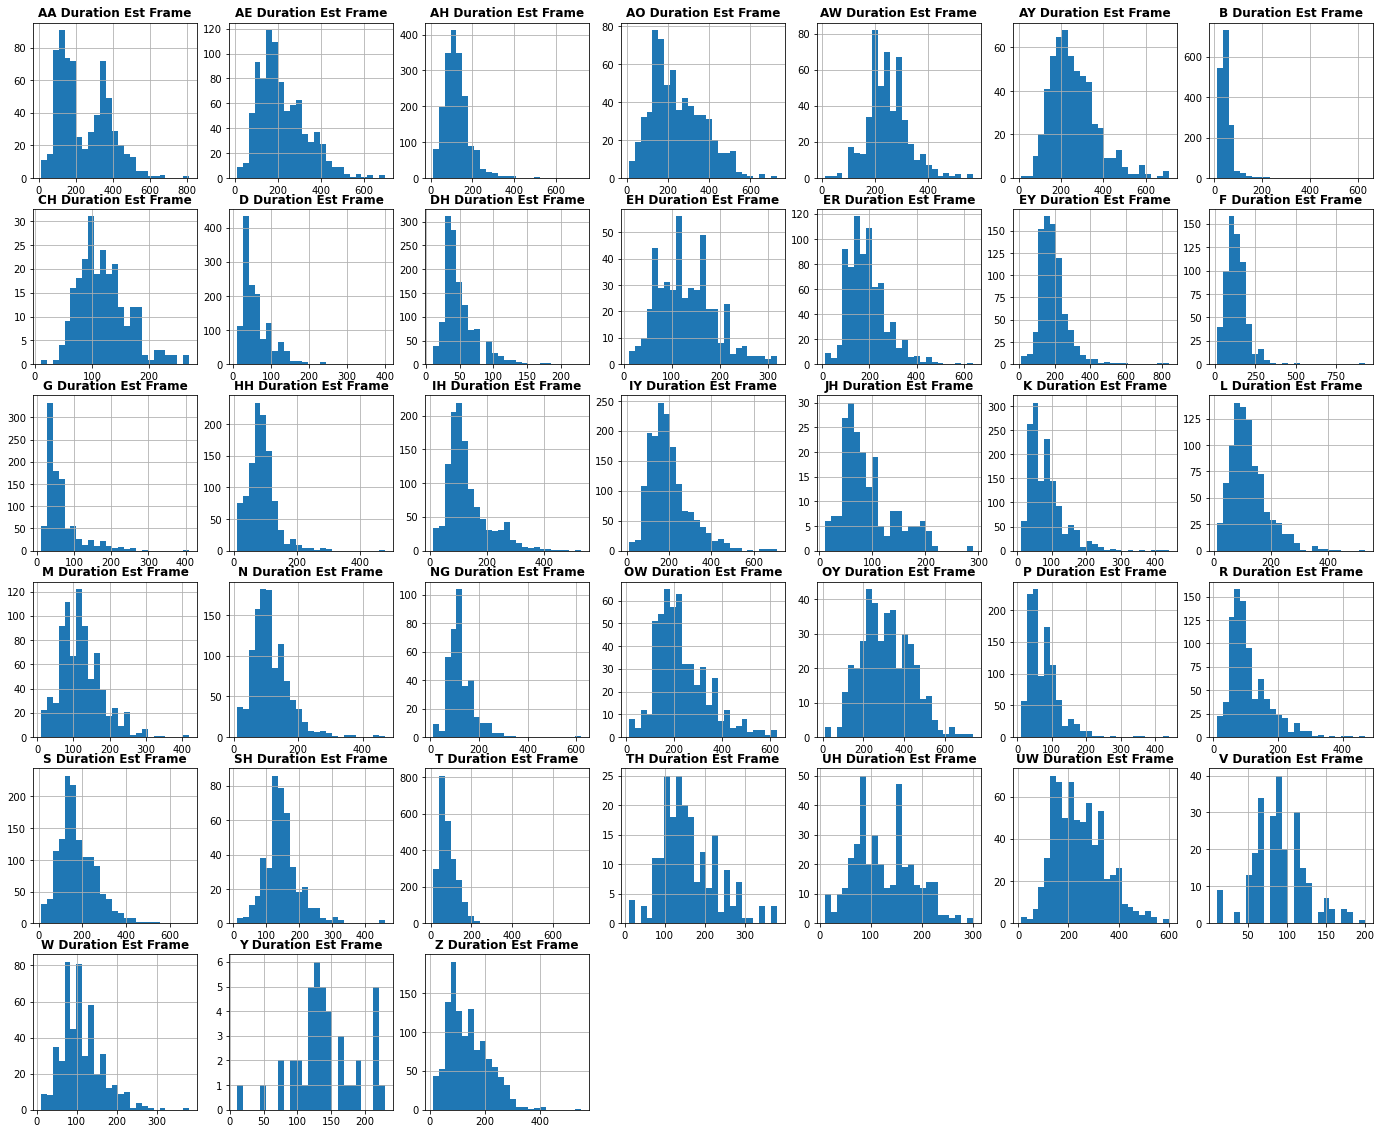

----------------------------------------------------------------------------------------------------------------------
Onset Error


In [ ]:
plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Durations')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    # durations = ['duration_est']
    plt.hist(_df['duration_est'].values, bins=25)    
    # sns.kdeplot(phone_dfs[phone]['frame'], x='duration_est')
    plt.grid()
    plt.title('%s Duration Est Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/phone_durations_frame.png')
plt.show()

plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Onset Error')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_frame'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_frame.png')
plt.show()

plt.figure(figsize=(24, 20))
print('----------------------------------------------------------------------------------------------------------------------')
print('Offset Error')
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['frame']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_frame'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err Frame' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_frame.png')
plt.show()


In [ ]:
print('----------------------------------------------------------------------------------------------------------------------')
print('Duration')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['duration_est_ivector'].values, bins=25)
    plt.grid()
    plt.title('%s Duration iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/phone_durations_ivec.png')
plt.show()
print('----------------------------------------------------------------------------------------------------------------------')
print('Onset Error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_ivector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_ivec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset Error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['ivector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_ivector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err iVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_ivec.png')
plt.show()


In [ ]:
print('----------------------------------------------------------------------------------------------------------------------')
print('duration')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['duration_est_xvector'].values, bins=25)
    plt.grid()
    plt.title('%s Duration xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/phone_durations_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Onset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['onset_err_xvector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Onset Err xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/onset_err_xvec.png')
plt.show()

print('----------------------------------------------------------------------------------------------------------------------')
print('Offset error')
plt.figure(figsize=(24, 20))
for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    _df = phone_dfs[phone]['xvector']
    plt.subplot(6, 7, ii+1)
    plt.hist(_df['offset_err_xvector'].values, bins=50, density=True)
    plt.xlim(-75, 75)
    plt.grid()
    plt.title('%s Offset Err xVec' % phone, fontweight='bold')
plt.savefig('./saved_figures/offset_err_xvec.png')
plt.show()

In [16]:
plt.figure(figsize=(20, 24))

dct = {}
phones = []

onset_error_mean_frame = []
onset_error_std_frame = []

onset_error_mean_xvec = []
onset_error_std_xvec = []

onset_error_mean_ivec = []
onset_error_std_ivec = []

offset_error_mean_frame = []
offset_error_std_frame = []

offset_error_mean_xvec = []
offset_error_std_xvec = []

offset_error_mean_ivec = []
offset_error_std_ivec = []

for ii, phone in enumerate(ENGLISH_PHONEME_LIST):
    
    df_dct = phone_dfs[phone]
    fdf = df_dct['frame']
    idf = df_dct['ivector']
    xdf = df_dct['xvector']
    
    if len(fdf['onset_err_frame'].values)==1:
        onset_error_mean_frame.append(np.nanmean(np.abs(fdf['onset_err_frame'].values)))
        onset_error_std_frame.append(0)
        offset_error_mean_frame.append(np.nanmean(np.abs(fdf['offset_err_frame'].values)))
        offset_error_std_frame.append(0)
    else:
        onset_error_mean_frame.append(np.nanmean(np.abs(fdf['onset_err_frame'].values)))
        onset_error_std_frame.append(np.nanstd(np.abs(fdf['onset_err_frame'].values)))
        offset_error_mean_frame.append(np.nanmean(np.abs(fdf['offset_err_frame'].values)))
        offset_error_std_frame.append(np.nanstd(np.abs(fdf['offset_err_frame'].values)))
        
    if len(idf['onset_err_ivector'].values)==1:
        onset_error_mean_ivec.append(np.nanmean(np.abs(idf['onset_err_ivector'].values)))
        onset_error_std_ivec.append(0)
        offset_error_mean_ivec.append(np.nanmean(np.abs(idf['offset_err_ivector'].values)))
        offset_error_std_ivec.append(0)       
    else:
        onset_error_mean_ivec.append(np.nanmean(np.abs(idf['onset_err_ivector'].values)))
        onset_error_std_ivec.append(np.nanstd(np.abs(idf['onset_err_ivector'].values)))
        offset_error_mean_ivec.append(np.nanmean(np.abs(idf['offset_err_ivector'].values)))
        offset_error_std_ivec.append(np.nanstd(np.abs(idf['offset_err_ivector'].values)))
    
    if len(xdf['offset_err_xvector'].values)==1:
        onset_error_mean_xvec.append(np.nanmean(np.abs(xdf['onset_err_xvector'].values)))
        onset_error_std_xvec.append(0)
        offset_error_mean_xvec.append(np.nanmean(xdf['offset_err_xvector'].values))
        offset_error_std_xvec.append(0)
    else:
        onset_error_mean_xvec.append(np.nanmean(np.abs(xdf['onset_err_xvector'].values)))
        onset_error_std_xvec.append(np.nanstd(np.abs(xdf['onset_err_xvector'].values)))
        offset_error_mean_xvec.append(np.nanmean(np.abs(xdf['offset_err_xvector'].values)))
        offset_error_std_xvec.append(np.nanstd(np.abs(xdf['offset_err_xvector'].values)))

    phones.append(phone)

    
datadf = pd.DataFrame.from_dict({'phone':phones, 'onset_err_frame':onset_error_mean_frame, 'onset_err_std_frame':onset_error_std_frame, 
                        'offset_err_frame': offset_error_mean_frame, 'offset_err_std_frame': offset_error_std_frame,
                        'onset_err_ivec': onset_error_mean_ivec, 'onset_err_std_ivec': onset_error_std_ivec, 
                        'offset_err_ivec': offset_error_mean_ivec, 'offset_err_std_ivec': offset_error_std_ivec, 
                        'onset_err_xvec': onset_error_mean_xvec, 'onset_err_std_xvec': onset_error_std_xvec, 
                        'offset_err_xvec': offset_error_mean_xvec, 'offset_err_std_xvec': offset_error_std_xvec}, orient='columns')

<Figure size 1440x1728 with 0 Axes>

In [26]:
import seaborn as sns
print('------------------------------------------------------------')
print('Onset Error(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_frame'].values), np.nanmean(datadf['onset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['onset_err_ivec'].values),  np.nanmean(datadf['onset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['onset_err_xvec'].values), np.nanmean(datadf['onset_err_std_xvec'].values)))

print('------------------------------------------------------------')

print('Offset errors(ms)')
print('FT\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_frame'].values),  np.nanmean(datadf['offset_err_std_frame'].values)))
print('Ivec\t %.2f, Std (%.2f)'%  (np.nanmean(datadf['offset_err_ivec'].values),  np.nanmean(datadf['offset_err_std_ivec'].values)))
print('Xvec\t %.2f, Std (%.2f)' % (np.nanmean(datadf['offset_err_xvec'].values),  np.nanmean(datadf['offset_err_std_xvec'].values)))

------------------------------------------------------------
Onset Error(ms)
FT	 18.83, Std (32.94)
Ivec	 18.46, Std (32.62)
Xvec	 18.25, Std (30.49)
------------------------------------------------------------
Offset errors(ms)
FT	 22.55, Std (37.57)
Ivec	 22.25, Std (37.35)
Xvec	 21.87, Std (35.07)


In [ ]:
for phone in phones:
    print('-----------------------------')
    print('Phone: \t %s' % phone)
    print()

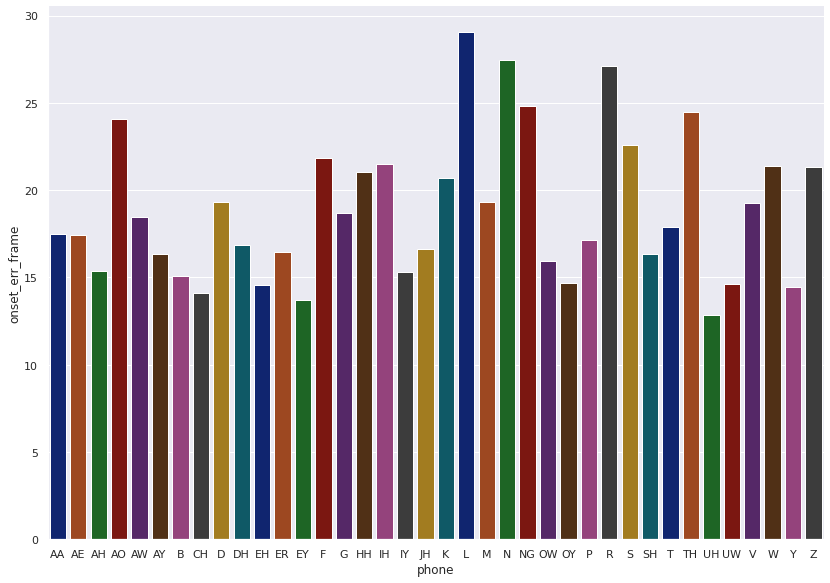

In [39]:
sns.catplot(data=datadf, kind='bar', x='phone', y='onset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

(array([4., 7., 8., 4., 3., 5., 2., 2., 2., 1.]), array([12.84420289, 14.46739048, 16.09057807, 17.71376566, 19.33695325,
       20.96014084, 22.58332843, 24.20651602, 25.82970361, 27.4528912 ,
       29.07607879]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

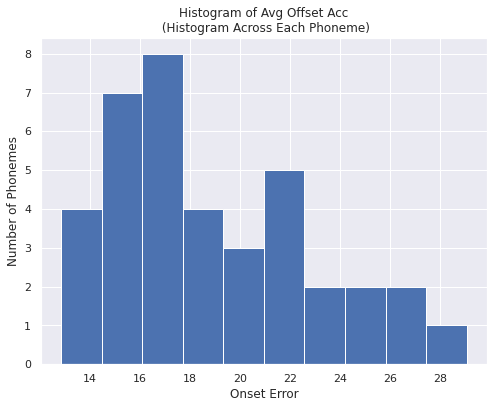

In [63]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_frame']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([ 2.,  3., 10.,  3.,  7.,  1.,  4.,  1.,  4.,  3.]), array([11.01294032, 12.63184582, 14.25075131, 15.86965681, 17.4885623 ,
       19.1074678 , 20.72637329, 22.34527879, 23.96418428, 25.58308977,
       27.20199527]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

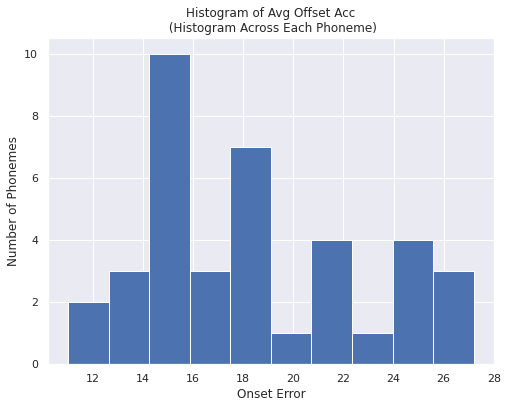

In [64]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_ivec']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([2., 6., 7., 5., 3., 5., 4., 0., 4., 2.]), array([11.36525213, 12.95279979, 14.54034746, 16.12789513, 17.7154428 ,
       19.30299047, 20.89053813, 22.4780858 , 24.06563347, 25.65318114,
       27.24072881]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

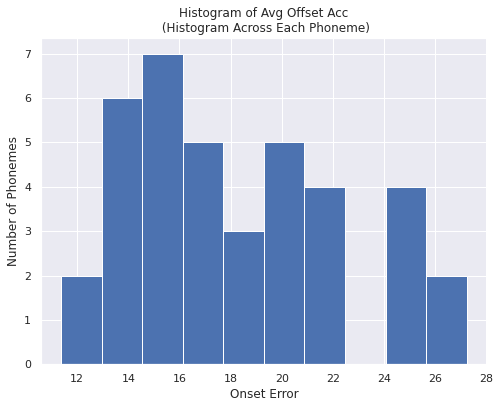

In [65]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_xvec']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([4., 7., 8., 4., 3., 5., 2., 2., 2., 1.]), array([12.84420289, 14.46739048, 16.09057807, 17.71376566, 19.33695325,
       20.96014084, 22.58332843, 24.20651602, 25.82970361, 27.4528912 ,
       29.07607879]), <a list of 10 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

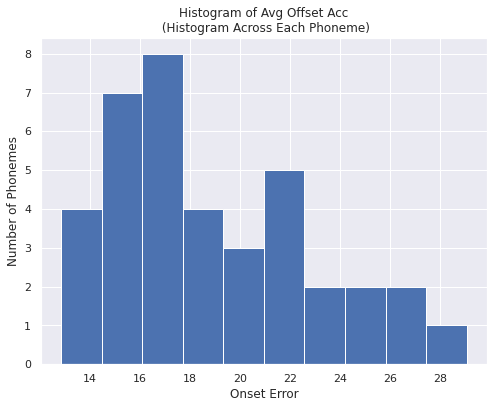

In [66]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['onset_err_frame']))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Onset Error')
plt.ylabel('Number of Phonemes')

(array([1., 0., 2., 4., 4., 1., 4., 4., 9., 2., 3., 0., 2., 1.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

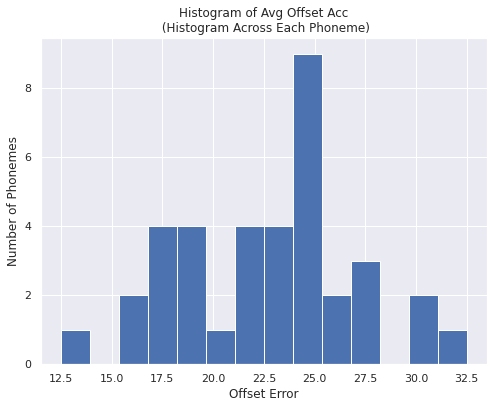

In [81]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_frame'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

(array([2., 2., 2., 2., 1., 3., 6., 4., 2., 7., 3., 2., 0., 1.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

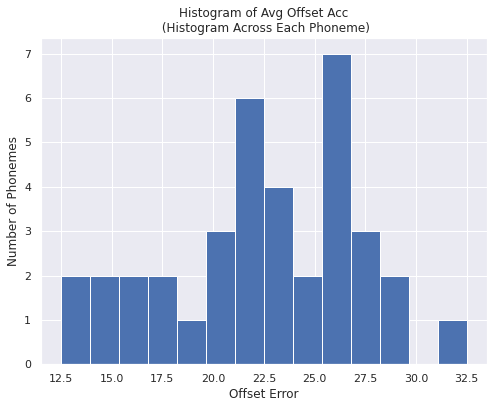

In [79]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_ivec'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

(array([3., 0., 2., 1., 3., 1., 6., 5., 6., 6., 1., 1., 1., 0.]), array([12.5       , 13.92857143, 15.35714286, 16.78571429, 18.21428571,
       19.64285714, 21.07142857, 22.5       , 23.92857143, 25.35714286,
       26.78571429, 28.21428571, 29.64285714, 31.07142857, 32.5       ]), <a list of 14 Patch objects>)


Text(0, 0.5, 'Number of Phonemes')

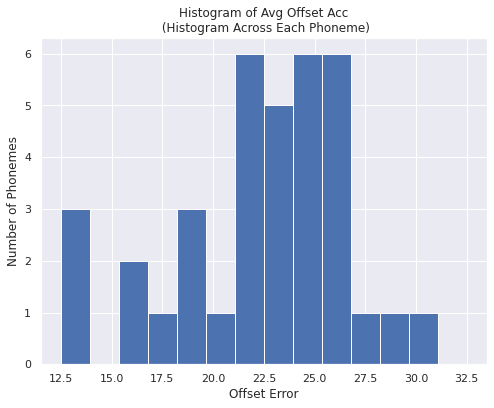

In [80]:
plt.figure(figsize=(8, 6))
print(plt.hist(datadf['offset_err_xvec'], bins=np.linspace(12.5, 32.5, 15)))
plt.title('Histogram of Avg Offset Acc\n (Histogram Across Each Phoneme)')
plt.xlabel('Offset Error')
plt.ylabel('Number of Phonemes')

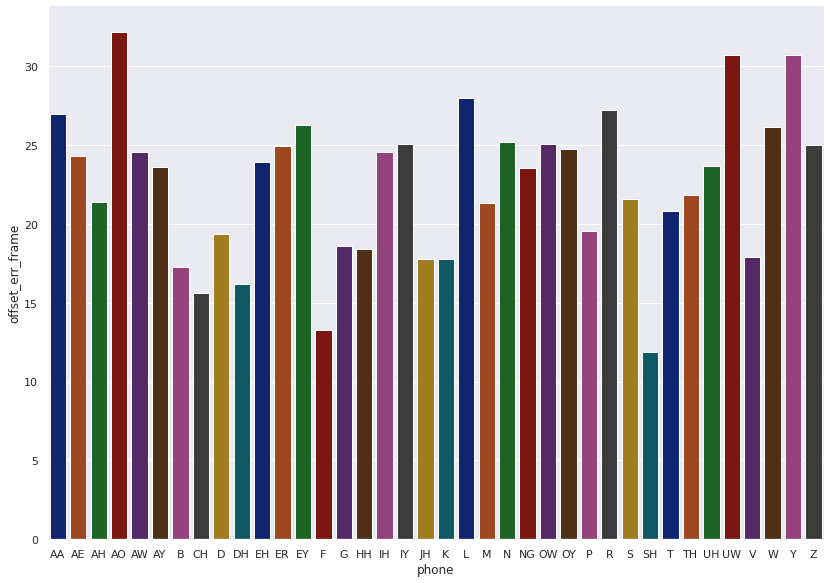

In [38]:
# plt.figure(figsize=(12,36))
# fig, ax = plt.subplots(figsize=(12,36))
# sns.set(rc={'figure.figsize':(12, 36)})
sns.catplot(data=datadf, kind='bar', x='phone', y='offset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

In [ ]:
# plt.figure(figsize=(12,36))
# fig, ax = plt.subplots(figsize=(12,36))
# sns.set(rc={'figure.figsize':(12, 36)})
sns.catplot(data=datadf, kind='bar', x='phone', y='offset_err_frame', height=8.27, aspect=11.7/8.27, palette=sns.color_palette('dark'))

In [13]:
np.mean(datadf['onset_err_frame'])

5.90656516910839

Start with a dictionary where the keys are all phonemes including silence
Then loop across speakers to calculate the following
Then loop through each phoneme in the textgrid

Average Phoneme Length plotting to find which ones get deleted often
- calculate the length of the phoneme for each case [manual, ivector, xvector, frame]

Onset/offset times
- create a function that compares the alignment accuracy in terms of onset/offset time
- for each phoneme 
- in a dictionary keep two lists for each phoneme: onset_time_errror and ofset_time_error
    
    
    

This thing should be easily parallelizable, you should learn how to parallelize it




In [ ]:
''' extract dictionary (speaker-wise) of the performance information'''

speaker_tgs = {}

for speaker_id in list(satdf.index):
    
    _results = {}
    tg_dct = {}

    tg_dct['Manual'] = manual_tgs_path
    tg_dct['iVec'] = finetuned_tgs_ivec
    tg_dct['xVec'] = finetuned_tgs_xvec
    tg_dct['Frame'] = finetuned_tgs_frame

In [ ]:
for speaker_id_in list(satdf.index):
    manual_tgs_path = [tgpath for tgpath in unmatched_manual_textgrid_files if speaker_id in tgpath]
    finetuned_tgs_ivec = get_all_textgrids_in_directory(results_dir_ivec, )

In [18]:
os.path.join(results_dir_frame, tgpath.split('/')[-2], tgpath.split('/')[-1])

'./results_frame_10epochs/results_sat/'

In [17]:
rslts_df.to_csv('./accuracy_results_ft_and_sat_methods.csv')

In [13]:
print(np.mean(rslts_df['PerfDiffiVec']))
print(np.mean(rslts_df['PerfDiffxVec']))

0.013917636604036807
0.014661981089438305


In [14]:
print(np.mean(rslts_df['iVecSATAccuracy']))
print(np.mean(rslts_df['xVecSATAccuracy']))

0.9184989953136226
0.9192433397990243


(array([1., 0., 0., 1., 0., 0., 1., 1., 0., 2.]),
 array([4.33333333, 4.575     , 4.81666667, 5.05833333, 5.3       ,
        5.54166667, 5.78333333, 6.025     , 6.26666667, 6.50833333,
        6.75      ]),
 <a list of 10 Patch objects>)

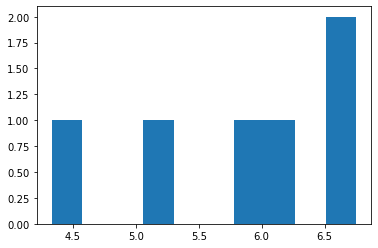

In [27]:
''' Plot histogram of Decliners'''
decliners_ivec = list(rslts_df[rslts_df['PerfDiffiVec']<0].index)
decliners_xvec = list(rslts_df[rslts_df['PerfDiffiVec']<0].index)

agedec_ivec = [int(spk[:2]) + float(spk[2:4])/12 for spk in decliners_ivec]
agedec_xvec = [int(spk[:2]) + float(spk[2:4])/12 for spk in decliners_xvec]
plt.hist(agedec_ivec)
# ydec_iv, xage1   = np.histogram(agedec_ivec)
# ydec_xv, xage2 = np.histogram(agedec_xvec)


# fig, ax = plt.subplots()
# rects1 = ax.bar(xage1[:-1], ydec_iv, width=0.35, label='iVec')
# rects2 = ax.bar(xage2[:-1], ydec_xv, width=0.35, label='xVec')
# ax.set_ylabel('Num Speakers')
# ax.set_title('Age of Speaker')
# ax.set_xticks(xage1, [str(ag) for ag in xage1[:-1]])
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# # rects1 = ax.bar(agedec,  width, label='Men')
# # rects2 = ax.bar(x + width/2, women_means, width, label='Women')


# plt.legend()
# plt.title('Age of Decliners')

Text(0, 0.5, 'Num Speakers')

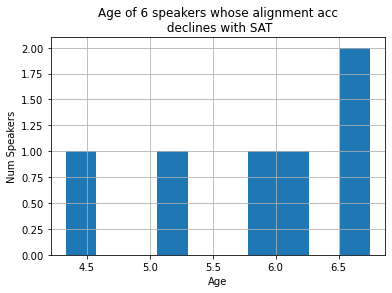

In [28]:
plt.hist(agedec_ivec)
plt.grid()
plt.title('Age of 6 speakers whose alignment acc\n declines with SAT')
plt.xlabel('Age')
plt.ylabel('Num Speakers')

In [17]:
decliners_xvec

['0609_F_AK', '0502_F_KM', '0603_M_LS', '0607_M_CE', '0404_M_TC', '0511_F_IG']

In [ ]:
improvers

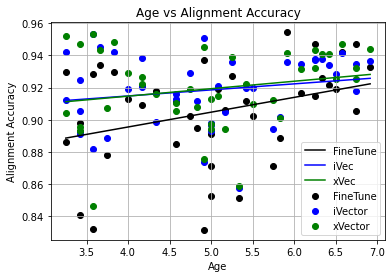

In [21]:
''' Scatter Age vs Alignment Accuracy'''
from sklearn.linear_model import LinearRegression

ages = [int(spk[:2]) + float(spk[2:4])/12 for spk in list(rslts_df.index)]
ages_lm = np.linspace(min(ages), max(ages), 100).reshape(-1, 1)

lmframe = LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['FrameWise_Acc'])
lmivec =  LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['iVecSATAccuracy'])
lmxvec =  LinearRegression().fit(np.array(ages).reshape(-1,1), rslts_df['xVecSATAccuracy'])
plt.scatter(ages, rslts_df['FrameWise_Acc'], c='k', label='FineTune')
plt.scatter(ages, rslts_df['iVecSATAccuracy'], c='b', label='iVector')
plt.scatter(ages, rslts_df['xVecSATAccuracy'], c='g', label='xVector')


plt.plot(ages_lm, lmframe.predict(ages_lm), 'k', label='FineTune')
plt.plot(ages_lm, lmivec.predict(ages_lm),'b', label='iVec')
plt.plot(ages_lm, lmxvec.predict(ages_lm), 'g', label='xVec')


plt.legend()
plt.title('Age vs Alignment Accuracy')
plt.xlabel('Age')
plt.ylabel('Alignment Accuracy')
plt.grid()

In [22]:
improvers_ivec = list(rslts_df[rslts_df['PerfDiffiVec']>.03].index)
improvers_xvec =  list(rslts_df[rslts_df['PerfDiffxVec']>.03].index)
print(improvers_ivec)
print(improvers_xvec)

['0500_M_QA', '0305_F_AN', '0411_M_LM', '0407_M_SJ', '0307_F_IC']
['0500_M_QA', '0305_F_AN', '0411_M_LM', '0305_F_MB', '0509_F_ES']


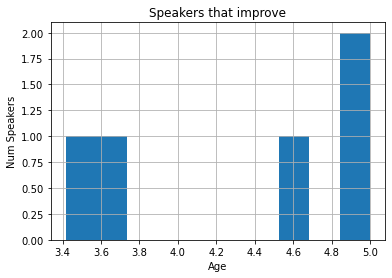

In [33]:
improvers=list(rslts_df[rslts_df['PerfDiffiVec']>.03].index)
plt.hist([int(imp[:2])+float(imp[2:4])/12 for imp in improvers])
plt.title('Speakers that improve')
plt.ylabel('Num Speakers')
plt.xlabel('Age')

plt.grid()

In [25]:
np.mean(rslts_df['SAT_Accuracy'])

0.9184989953136228

In [26]:
print(np.mean(rslts_df['PerfDiff']))
print(np.max(rslts_df['PerfDiff']))

0.013917636604036807
0.04988344988344984


Text(0, 0.5, 'Number of Speakers')

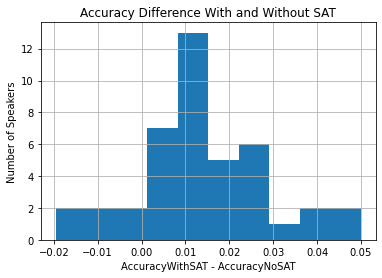

In [28]:
plt.figure()
plt.hist(rslts_df['PerfDiff'].values)
# plt.xlim([-.1, .25])
plt.grid()
plt.title('Accuracy Difference With and Without SAT')
plt.xlabel('AccuracyWithSAT - AccuracyNoSAT')
plt.ylabel('Number of Speakers')

In [ ]:
perf_dif = rslts_df['PerfDiff'].values[rslts_df['PerfDiff']<0]
np.mean(perf_dif)
np.max(perf_dif)

In [ ]:
strange_idxs = np.argwhere(np.array(perfdif)<0).ravel()
strange_speakers = [perf_diff[sidxs] for sidxs in strange_idxs]

In [ ]:
strange_speakers

In [ ]:
asdf = np.random.rand(1000)
xmin = -2.5
xmax = 7
plt.hist(asdf, bins=100)

In [62]:
''' 
create a 5 part dataset
'''

def piecewise_posterior(npoints=10000, n_components=5, priors=None, xmin=0, xmax=1):
    x = np.random.rand(npoints) 
    x = x  * (xmax - xmin) + xmin
    
    
    y = np.zeros_like(x) 
    posterior = np.zeros_like(x)
    
    
    